In [1]:
import pandas as pd

# Load CSV
df = pd.read_csv("/Users/nhuquynhtran/Downloads/Tensorflow Env (Latest)/XAI-project/skincancer-dataset/HAM10000_metadata")

# View unique classes
print(df["dx"].unique())

['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


In [2]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode text labels to class indices
le = LabelEncoder()
df['label_idx'] = le.fit_transform(df['dx'])  # e.g. 'bkl' -> 2

# One-hot encode the class indices
df['label_onehot'] = list(to_categorical(df['label_idx']))

In [3]:
import random

# How many samples per class (you can change this)
samples_per_class = 100

# Store selected image IDs
selected_image_ids = []

# Get unique classes
unique_classes = df["dx"].unique()

for cls in unique_classes:
    class_df = df[df["dx"] == cls]
    sampled_ids = class_df.sample(n=samples_per_class, random_state=42)["image_id"].tolist()
    selected_image_ids.extend(sampled_ids)

# Filter metadata for selected images only
df_subset = df[df["image_id"].isin(selected_image_ids)].reset_index(drop=True)
print("Subset shape:", df_subset.shape)
print(df_subset["dx"].value_counts())

Subset shape: (700, 10)
dx
bkl      100
df       100
mel      100
vasc     100
bcc      100
nv       100
akiec    100
Name: count, dtype: int64


In [4]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
from sklearn.metrics import classification_report
from keras.applications import *
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from sklearn.utils import class_weight
from tqdm import tqdm
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet_v2 import preprocess_input as base_preprocess
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.utils.multiclass import unique_labels
from collections import Counter
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import itertools

In [5]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Base image directory
image_root_dir = "/Users/nhuquynhtran/Downloads/Tensorflow Env (Latest)/XAI-project/skincancer-dataset/HAM10000_images"
img_size = (224, 224)

data = []
labels = []

for _, row in df_subset.iterrows():
    image_filename = row["image_id"] + ".jpg"
    found = False
    for subfolder in os.listdir(image_root_dir):
        image_path = os.path.join(image_root_dir, subfolder, image_filename)
        if os.path.exists(image_path):
            img = load_img(image_path, target_size=img_size)
            img_array = img_to_array(img) / 255.0
            data.append(img_array)
            found = True
            break
    if not found:
        print(f"Image {image_filename} not found!")

# Encode labels and one-hot
le = LabelEncoder()
df_subset['label_idx'] = le.fit_transform(df_subset['dx'])
labels = to_categorical(df_subset['label_idx'])

data = np.array(data)
labels = np.array(labels)

print("Loaded images shape:", data.shape)
print("Labels shape:", labels.shape)

Loaded images shape: (700, 224, 224, 3)
Labels shape: (700, 7)


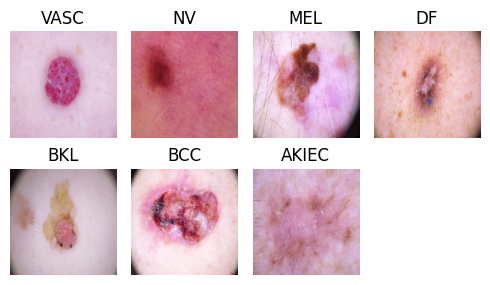

In [6]:
# Get unique class labels and their corresponding indices in the data array
unique_classes = np.unique(labels, axis=1)

# Create a dictionary to store one data sample from each class
class_samples = {}

# Map class indices to their corresponding names
class_names = {0: "AKIEC", 1: "BCC", 2: "BKL", 3: "DF", 4: "MEL", 5: "NV", 6: "VASC"}

# Select one data sample from each class
for class_label in unique_classes:
    class_indices = np.where(np.all(labels == class_label, axis=1))[0]
    class_samples[tuple(class_label)] = data[class_indices[0]]

# Plot the images in 2 rows
plt.figure(figsize=(5, 3))
for i, (class_label, image_data) in enumerate(class_samples.items()):
    class_index = np.argmax(class_label)  # Get the index of the class
    class_name = class_names[class_index]  # Get the corresponding class name
    plt.subplot(2, 4, i + 1)
    plt.imshow(image_data)
    plt.title(f'{class_name}')
    plt.axis('off')

plt.tight_layout()
plt.show()

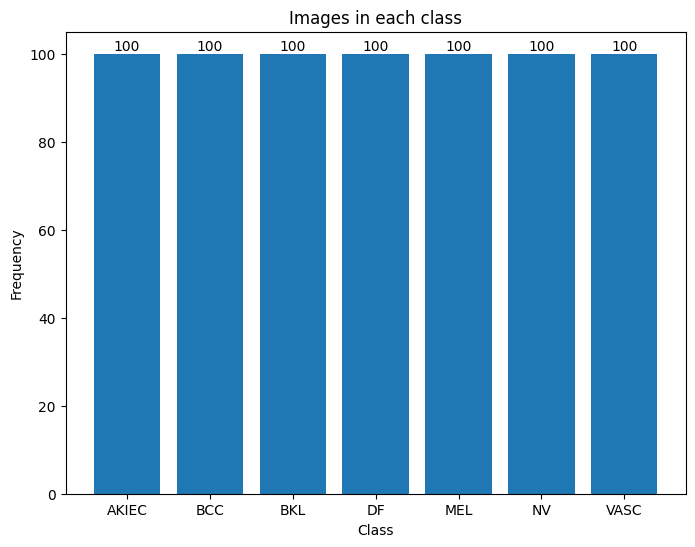

In [7]:
# Sum the one-hot encoded labels along the rows to get the frequency of each class
class_counts = np.sum(labels, axis=0)

# Map class indices to their corresponding names
class_names = {0: "AKIEC", 1: "BCC", 2: "BKL", 3: "DF", 4: "MEL", 5: "NV", 6: "VASC"}

# Plot the class frequencies
plt.figure(figsize=(8, 6))
plt.bar([class_names[class_idx] for class_idx in range(len(class_names))], class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Images in each class')

# Annotate the bars with the class frequencies (integer format)
for i, count in enumerate(class_counts):
    plt.text(i, count, str(int(count)), ha='center', va='bottom')

plt.show()

In [8]:
# Split the data into train, test, and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1,stratify=labels, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.1,stratify=train_labels, random_state=42)

In [9]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [10]:
import os
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Define local directory to save the model
save_dir = './saved_models_skincancer'
os.makedirs(save_dir, exist_ok=True)  # Create if not exists

# Define callbacks
lr_reduce = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    mode='max',
    min_lr=1e-4,
    verbose=1
)

# Set full path to save model locally
saved_model_path = os.path.join(save_dir, 'EfficientNetV2S.h5')

# Model checkpoint callback
model_chkpt = ModelCheckpoint(
    saved_model_path,
    save_best_only=True,
    monitor='val_accuracy',
    verbose=1
)

# Callback list to use during model training
callback_list = [model_chkpt, lr_reduce]

In [ ]:
base_model = EfficientNetV2M(weights='imagenet',
                        include_top=False,
                        input_shape=(224, 224, 3))

2025-07-10 22:07:48.159208: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-07-10 22:07:48.159428: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-07-10 22:07:48.159432: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1752160068.159959 2357418 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1752160068.160008 2357418 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 10
batch_size = 16

In [ ]:
history = model.fit(datagen.flow(train_data, train_labels, batch_size=batch_size),
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    callbacks=callback_list)

Epoch 1/10


/Users/nhuquynhtran/Downloads/Tensorflow Env (Latest)/tf219-env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-07-10 18:45:12.122067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.2286 - loss: 1.9686 
Epoch 1: val_accuracy improved from -inf to 0.17460, saving model to ./saved_models_skincancer/EfficientNetV2S.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 1701s 23s/step - accuracy: 0.2294 - loss: 1.9677 - val_accuracy: 0.1746 - val_loss: 2.1273 - learning_rate: 0.0010
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.2983 - loss: 1.9680 
Epoch 2: val_accuracy did not improve from 0.17460
71/71 ━━━━━━━━━━━━━━━━━━━━ 1820s 25s/step - accuracy: 0.2983 - loss: 1.9669 - val_accuracy: 0.1429 - val_loss: 2.0595 - learning_rate: 0.0010
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.3096 - loss: 1.8443 
Epoch 3: val_accuracy did not improve from 0.17460
71/71 ━━━━━━━━━━━━━━━━━━━━ 1704s 24s/step - accuracy: 0.3095 - loss: 1.8441 - val_accuracy: 0.1111 - val_loss: 2.2950 - learning_rate: 0.0010
Epoch 4/10
13/71 ━━━━━━━━━━━━━━━━━━━━ 17:26 18s/step - accuracy: 0.2951 - loss: 1.7166